In [1]:
from PIL import Image, ImageOps
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier

In [2]:
def aanmakenDf (groep, label):
#Drie lege lijsten worden aangemaakt die dan uiteindelijk samen dataframe zullen vormen 
    Pixels= []
    Label =[]
  
#fotos inlezen en omzetten per groep. 
    for foto in os.listdir(groep):
        beeld = Image.open(groep+foto)
#fotos omzetten in grijswaarde of 2 dimensionele array ipv 3x2
        beeld_grijs = ImageOps.grayscale(beeld)

#fotos resizen voor leesbaarheid tijdens testen, en eventueel voor latere experimenten
        beeld_formaat = beeld_grijs.resize((beeld_grijs.width // 1, beeld_grijs.height //1 ))       
        
#fotos omzetten naar numpy array
        data_2dim = np.asarray(beeld_formaat, dtype=np.uint8)
        data = data_2dim.flatten()

#3 lijsten opvullen, eerste met data van foto, tweede met label en derde met naam van foto. 
#De lengte van elke lijst = aantal fotos in bijhorende map
        Pixels.append(data)
        Label.append(label)

#Per groep worden de drie aangemaakte lijsten omgezet naar panda df

    dict = {'data': Pixels, 'label': Label}
    df = pd.DataFrame(dict)
    return df

In [3]:
#Dataframe aanmaken
aanwezig = r"classificatie/aanwezig/"  #852 foto's 
buiten = r"classificatie/buiten/"       #389 foto's
niets = r"classificatie/niets/"         #1399 foto's
#Eerst wordt per map een panda dataframe aangemaakt
nietsDf = aanmakenDf(niets, 0)
aanwezigDf = aanmakenDf(aanwezig, 1)
buitenDf = aanmakenDf(buiten, 2)
#vervolgens worden ze alle drie samengevoegd tot 1 groot dataframe
volledigDataframe = pd.concat([nietsDf, aanwezigDf, buitenDf], ignore_index=True)

In [4]:
#Opsplitsen in gestratificieerde testset en trainingsset
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(volledigDataframe, volledigDataframe['label']):
    strat_train_set = volledigDataframe.loc[train_index]
    strat_test_set = volledigDataframe.loc[test_index] 
#X = data, y = label. Dit voor trainingsset en testset

X_train, X_test, y_train, y_test = strat_train_set['data'], strat_test_set['data'], strat_train_set['label'], strat_test_set['label']

In [5]:
X_train.info()

<class 'pandas.core.series.Series'>
Int64Index: 2112 entries, 1439 to 2510
Series name: data
Non-Null Count  Dtype 
--------------  ----- 
2112 non-null   object
dtypes: object(1)
memory usage: 33.0+ KB


In [6]:
X_test.info()

<class 'pandas.core.series.Series'>
Int64Index: 528 entries, 883 to 592
Series name: data
Non-Null Count  Dtype 
--------------  ----- 
528 non-null    object
dtypes: object(1)
memory usage: 8.2+ KB


In [7]:
#Omzetten naar np.array
X_train_array = np.array(X_train.tolist())
X_test_array = np.array(X_test.tolist())
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)


improve the result by scaling

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_array.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test_array.astype(np.float64))
#cross_val_score(forest_clf, X_train_scaled, y_train_array, cv=3, scoring="accuracy")

In [9]:
#RandomforestClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42, min_samples_split = 2,n_estimators= 300, max_leaf_nodes = 50)
#forest_clf.fit(X_train_array, y_train_array)
forest_clf.fit(X_train_scaled, y_train_array)

RandomForestClassifier(max_leaf_nodes=50, n_estimators=300, random_state=42)

0: 0.94034091
1: 0.94886364
2: 0.93465909

In [10]:
import joblib
joblib.dump(forest_clf, "models/test.pkl")
#...
#my_model_loaded = joblib.load("models/my_model.pkl")

['models/test.pkl']

TEST

In [11]:
X_test_scaled.size

118947840

In [12]:
from sklearn.metrics import accuracy_score
y_pred = forest_clf.predict(X_test_scaled)
print(forest_clf.__class__.__name__, accuracy_score(y_test_array, y_pred))

RandomForestClassifier 0.9488636363636364


In [13]:
# reshape X_test_scaled
X_test_scaled.reshape(528,225280)

array([[-0.02734288, -0.5941908 ,  0.50236406, ..., -0.14418296,
        -0.64238405, -0.94503622],
       [-0.1746596 , -1.03758455, -0.07080137, ...,  0.07663967,
         0.10588303,  0.13447413],
       [ 1.29850766,  1.74946184,  1.71237996, ...,  0.13184533,
        -0.21480286, -0.50341835],
       ...,
       [-0.54295142, -0.21413902, -0.89870699, ...,  0.73910757,
         0.58691187,  0.42888604],
       [ 0.48826567,  1.1160422 ,  1.20289958, ..., -1.68994138,
        -1.87167996, -1.92640926],
       [ 0.4146073 ,  0.35593865,  0.50236406, ..., -0.42021125,
        -0.10790756,  0.08540548]])

In [14]:
X_test_shape = X_test_scaled.reshape(528,225280)

In [15]:
X_test_shape.size

118947840

In [16]:
digit = X_test_scaled[0]
digit

array([-0.02734288, -0.5941908 ,  0.50236406, ..., -0.14418296,
       -0.64238405, -0.94503622])

In [17]:
kat = digit.reshape(352,640)

In [18]:
proba_np_array = np.zeros(528)
pred_np_array = np.zeros(528)
for i in range (528):
    test_musti = X_test_scaled[i]
    test_musti_2D = test_musti.reshape(1,-1)
    proba = forest_clf.predict_proba(test_musti_2D)
    max_proba = np.amax(proba)
    proba_np_array[i] = max_proba
    pred = forest_clf.predict(test_musti_2D)
    pred_np_array[i] = pred[0]
proba_np_array

array([0.98503769, 0.99496095, 0.81350925, 0.68663507, 0.95071342,
       0.90220268, 0.98402752, 0.94150565, 0.49877314, 0.6293093 ,
       0.99444623, 0.96435463, 0.56967245, 0.5078889 , 0.77603063,
       0.97542097, 0.97567413, 0.95704953, 0.9697862 , 0.95710196,
       0.92083072, 0.93397163, 0.97075053, 0.64933424, 0.75903053,
       0.98931725, 0.99272529, 0.91303712, 0.84761524, 0.55476742,
       0.96986516, 0.90604985, 0.93126101, 0.95317498, 0.99441038,
       0.75163948, 0.92849409, 0.83342238, 0.97743671, 0.53033291,
       0.91621619, 0.9419248 , 0.9889111 , 0.96423056, 0.94257169,
       0.89587824, 0.95435958, 0.98101374, 0.93924197, 0.92554745,
       0.9265565 , 0.97080035, 0.99496095, 0.76573545, 0.90468027,
       0.72632964, 0.80824396, 0.99168924, 0.98276163, 0.99496095,
       0.84640379, 0.98902708, 0.77388651, 0.95994735, 0.94602418,
       0.98973419, 0.93265191, 0.79880989, 0.89372753, 0.81761301,
       0.62920388, 0.99267115, 0.99200239, 0.99293033, 0.82320

In [19]:
proba_np_array.mean()

0.8881500563367409

In [20]:
proba_np_array.sort()
(proba_np_array[528 // 2] + proba_np_array[(528 // 2) + 1]) / 2

0.9475344737606678

<AxesSubplot:>

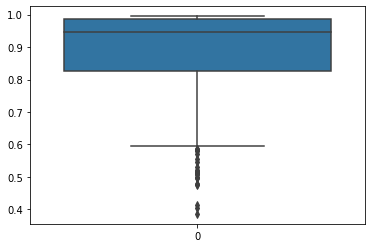

In [21]:
import seaborn as sns
sns.boxplot(data = proba_np_array)

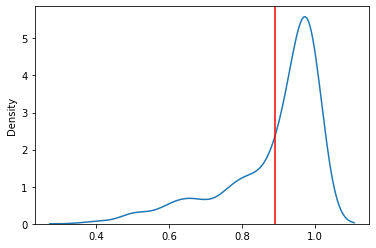

In [22]:
sns.kdeplot(data = proba_np_array)
plt.axvline(0.89, color='r')
plt.show()

In [23]:
np.quantile(proba_np_array, 0.25)

0.8272605539732174

In [32]:
test_frame = pd.DataFrame({'real': y_test_array, 'predict': pred_np_array})
test_frame = test_frame.astype(int)
test_frame["real_text"] = np.where(test_frame['real']== 0, "niets", np.where(test_frame['real']== 1, "binnen", "buiten"))
test_frame["predic_text"] = np.where(test_frame['real']== 0, "niets", np.where(test_frame['real']== 1, "binnen", "buiten"))
test_frame.head()

,real,predict,real_text,predic_text
0,0,0,niets,niets
1,0,0,niets,niets
2,2,2,buiten,buiten
3,1,1,binnen,binnen
4,0,0,niets,niets


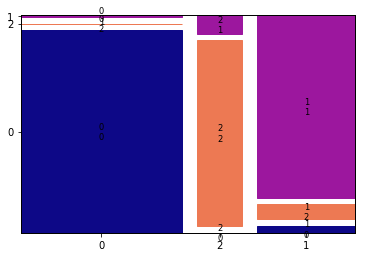

In [36]:
from matplotlib import cm
from statsmodels.graphics.mosaicplot import mosaic  # Mosaic diagram

# By default, mosaic() will color all columns the same. Here,
# we're going to give a separate color to each response (1-5).
# The response is kept in the label of each cell, a tuple of
# the two values that are represented in that cell (e.g.
# ('Female', '2')). We will be using the "plasma" color map
# in this example.
plasma_colors = cm.get_cmap('plasma')
# Create a function that maps the cell key to the color we
# want to give it. We use the colormap function created above
# and give it a number between 0 and 1. We convert the second
# part of the key (values '1' to '5') to a number and divide
# by 5.
props = lambda key: {'color': plasma_colors(int(key[1])/3)}

mos_gender_survey = mosaic(
       data=test_frame, index=['real', 'predict'],
       gap=0.05, properties=props)

<AxesSubplot:xlabel='real_text', ylabel='predic_text'>

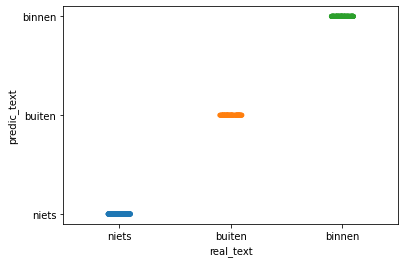

In [37]:
sns.stripplot(x="real_text", y="predic_text", data = test_frame)